In [ ]:
#| default_exp ocr_idefics

In [ ]:
#| export

from __future__ import annotations


In [ ]:
#| hide
# %reload_ext autoreload
# %autoreload 0


# Testing `Idefics` OCR for Comics
> Accuracy Enhancements for OCR in `PanelCleaner`


# Prologue

In [ ]:
#| export
import subprocess
from pathlib import Path
from typing import Any
from typing import Literal
from typing import TypeAlias

import torch
import transformers.image_utils as image_utils
from PIL import Image
from rich.console import Console
from transformers import AutoProcessor
from transformers import Idefics2ForConditionalGeneration

from testbed.experiments import OCRExperimentContext
from testbed.helpers import IN_MAC
from testbed.helpers import IN_LINUX
from testbed.helpers import default_device
from testbed.ocr_metric import remove_multiple_whitespaces


In [ ]:
import os
import re
import sys
from io import BytesIO
from typing import cast

import fastcore.all as FC
import fastcore.xtras  # patch pathlib.Path with some utils
import requests
import transformers
from fastcore.test import *  # type: ignore
from transformers import AutoModelForVision2Seq
from transformers import BitsAndBytesConfig

from testbed.helpers import display_image_grid
from testbed.helpers import default_device
from testbed.ocr_metric import postprocess_ocr


need version >4.40 of transformers

In [ ]:
transformers.__version__

'4.42.0.dev0'

In [ ]:
# %pip install git+https://github.com/huggingface/transformers

# Helpers

In [ ]:
# pretty print by default
# %load_ext rich

In [ ]:
#| exporti

console = Console(width=104, tab_size=4, force_jupyter=True)
cprint = console.print


Force reload of `experiments` module

In [ ]:
if 'pcleaner._testbed.testbed.experiments' in sys.modules:
    import importlib; importlib.reload(pcleaner._testbed.testbed.experiments)  # type: ignore
else:
    import pcleaner._testbed.testbed.experiments
    from pcleaner._testbed.testbed.experiments import *


In [ ]:
from testbed.helpers import RenderJSON
from testbed.web_server import setup_ngrok
from testbed.web_server import WebServerBottle


In [ ]:
#| exporti

if IN_MAC:
    import mlx.core as mx
    from mlx_vlm import load, generate


In [ ]:
#| exporti

def load_image(img_ref: str | Path | Image.Image) -> Image.Image:
    return image_utils.load_image(str(img_ref) if isinstance(img_ref, Path) else img_ref)


In [ ]:
#| exporti

def get_gpu_vram(total=True):
    if total:
        if IN_MAC:
            return mx.metal.device_info()['memory_size']//1024//1024
        else:
            command = "nvidia-smi --query-gpu=memory.total --format=csv,noheader,nounits"
    else:
        if IN_MAC:
            return mx.metal.get_active_memory()//1024//1024
        else:
            command = "nvidia-smi --query-gpu=memory.used --format=csv,noheader,nounits"
    try:
        vram = subprocess.check_output(command, shell=True).decode('utf-8').strip()
        return vram
    except subprocess.CalledProcessError:
        return "Failed to get VRAM"


# GPU

In [ ]:
DEVICE = default_device()
DEVICE


'mps'

In [ ]:
if IN_MAC:
    cprint(
        f"{'metal.is_available()':>30}: {mx.metal.is_available()}\n"
        f"{'metal.device_info()':>30}: {mx.metal.device_info()}\n"
        f"{'metal.get_active_memory()':>30}: {mx.metal.get_active_memory()//1024//1024}\n"
        f"{'metal.get_peak_memory()':>30}: {mx.metal.get_peak_memory()//1024//1024}\n"
        f"{'metal.get_cache_memory()':>30}: {mx.metal.get_cache_memory()//1024//1024}\n"
    )
else:
    !nvidia-smi

cprint( f"{'total VRAM':>15}: {get_gpu_vram()} MiB\n"
        f"{'active VRAM':>15}: {get_gpu_vram(False)} MiB")



metal.is_available(): True
           metal.device_info(): {'memory_size': 68719476736, 'max_recommended_working_set_size': 
51539607552, 'max_buffer_length': 38654705664, 'architecture': 'applegpu_g13s'}
     metal.get_active_memory(): 0
       metal.get_peak_memory(): 0
      metal.get_cache_memory(): 0

total VRAM: 65536 MiB
    active VRAM: 0 MiB

----
# Idefics basic usage


## [Model card](https://huggingface.co/HuggingFaceM4/idefics2-8b) examples

In [ ]:
url1 = "https://cdn.britannica.com/61/93061-050-99147DCE/Statue-of-Liberty-Island-New-York-Bay.jpg"
url2 = "https://cdn.britannica.com/59/94459-050-DBA42467/Skyline-Chicago.jpg"
image1 = load_image(url1)
image2 = load_image(url2)

display_image_grid([url1, url2], rows=1, columns=2)

,


In [ ]:
processor = AutoProcessor.from_pretrained(
    "HuggingFaceM4/idefics2-8b", 
    do_image_splitting=False, 
    )


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Half precission (+ Flash Attention)

In [ ]:
if IN_MAC:
    model = AutoModelForVision2Seq.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,
    ).to(DEVICE)
else:
    model = AutoModelForVision2Seq.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,    
        _attn_implementation="flash_attention_2",
    ).to(DEVICE)


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# Create inputs
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "What do we see in this image?"},
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "In this image, we can see the city of New York, and more specifically the Statue of Liberty."},
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "And how about this image?"},
        ]
    },       
]
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)


In [ ]:
inputs = processor(text=prompt, images=[image1, image2], return_tensors="pt")
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

# Generate
generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

cprint(generated_texts[0].split('\n'))
# ['User: What do we see in this image? \nAssistant: In this image, we can see the city of New York, and more specifically the Statue of Liberty. \nUser: And how about this image? \nAssistant: In this image we can see buildings, trees, lights, water and sky.']

[
    'User: What do we see in this image? ',
    'Assistant: In this image, we can see the city of New York, and more specifically the Statue of 
Liberty. ',
    'User: And how about this image? ',
    'Assistant: In this image we can see buildings, trees, lights, water and sky.'
]

In [ ]:
del model
if IN_LINUX:
    torch.cuda.empty_cache()
if IN_MAC:
    mx.metal.clear_cache()
import gc
gc.collect()


38

### 4-bit quantization with bitsandbytes (+ Flash Attention)


In [ ]:
if IN_LINUX:
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.float16
    )

    model = AutoModelForVision2Seq.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,    
        quantization_config=quantization_config,
        _attn_implementation="flash_attention_2",
    )


In [ ]:
if IN_LINUX:
    inputs = processor(text=prompt, images=[image1, image2], return_tensors="pt")
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}


    # Generate
    generated_ids = model.generate(**inputs, max_new_tokens=500)
    generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

    cprint(generated_texts[0].split('\n'))
    # ['User: What do we see in this image? \nAssistant: In this image, we can see the city of New York, and more specifically the Statue of Liberty. \nUser: And how about this image? \nAssistant: In this image we can see buildings, trees, lights, water and sky.']

In [ ]:
del processor
if IN_LINUX:
    del model
    torch.cuda.empty_cache()
if IN_MAC:
    mx.metal.clear_cache()
import gc
gc.collect()


0

## OCR

In [ ]:
# prompt_text = (
#         "Please perform optical character recognition (OCR) on this image, which displays "
#         "speech balloons from a comic book. The text is in English. Extract the text and "
#         "format it as follows: transcribe in standard sentence case, capitalized. Avoid using "
#         "all capital letters, but ensure it is capitalized where appropriate, including proper nouns. "
#         "Provide the transcribed text clearly. Double check the text is not all capital letters.")

prompt_text = (
        "Do perform optical character recognition OCR on the image, which contains speech "
        "balloons from a comic book. The text is in English. Carefully extract the text exactly "
        "as it appears, ensuring that you preserve the original capitalization, punctuation, and "
        "formatting."
)

# prompt_text = (
#         "Perform optical character recognition OCR on this image, which contains speech "
#         "balloons from a comic book. The text is in English."
# )


resulting_messages = [
    {
        "role": "user",
        "content": [{"type": "image"}] + [
            {"type": "text", "text": prompt_text}
        ]
    }
]
resulting_messages

[{'role': 'user',
  'content': [{'type': 'image'},
   {'type': 'text',
    'text': 'Do perform optical character recognition OCR on the image, which contains speech balloons from a comic book. The text is in English. Carefully extract the text exactly as it appears, ensuring that you preserve the original capitalization, punctuation, and formatting.'}]}]

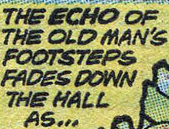

In [ ]:
image_url = Path('../experiment/cache/Strange_Tales_172005/_crop/Strange_Tales_172005_7_Initial box.png')
image1 = Image.open(image_url)
display(image1)


In [ ]:
def idefics_generation_args(processor, device, image: Image.Image, resulting_messages: list[dict]):
    prompt = processor.apply_chat_template(resulting_messages, add_generation_prompt=True)
    inputs = processor(text=prompt, images=[image], return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    max_new_tokens = 512
    repetition_penalty = 1.2
    decoding_strategy = "Greedy"
    temperature = 0.4
    top_p = 0.8

    generation_args = {
        "max_new_tokens": max_new_tokens,
        "repetition_penalty": repetition_penalty,
    }

    assert decoding_strategy in [
        "Greedy",
        "Top P Sampling",
    ]

    if decoding_strategy == "Greedy":
        generation_args["do_sample"] = False
    elif decoding_strategy == "Top P Sampling":
        generation_args["temperature"] = temperature
        generation_args["do_sample"] = True
        generation_args["top_p"] = top_p

    generation_args.update(inputs)
    return prompt, generation_args


In [ ]:
processor = AutoProcessor.from_pretrained(
    "HuggingFaceM4/idefics2-8b", 
    do_image_splitting=False, 
)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Half precission

In [ ]:
if IN_MAC:
    model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b", 
        torch_dtype=torch.float16,
        device_map='auto', 
        )
else:
    model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b", 
        torch_dtype=torch.float16,
        device_map='auto', 
        _attn_implementation="flash_attention_2",
    )


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
prompt, generation_args = idefics_generation_args(processor, model.device, image1, resulting_messages)
generated_ids = model.generate(**generation_args)
generated_texts = processor.batch_decode(
    generated_ids[:, generation_args["input_ids"].size(1):], skip_special_tokens=True)
cprint(prompt, generated_texts)


User:<image>Do perform optical character recognition OCR on the image, which contains speech balloons 
from a comic book. The text is in English. Carefully extract the text exactly as it appears, ensuring 
that you preserve the original capitalization, punctuation, and formatting.<end_of_utterance>
Assistant:
['THE ECHO OF THE OLD MAN\'S FOOTSTEPS FADES DOWN THE HALL AS"']

In [ ]:
del model
if IN_LINUX:
    torch.cuda.empty_cache()
if IN_MAC:
    mx.metal.clear_cache()
import gc
gc.collect()


38

### 8-bit quantization (Mac with mlx, Linux with bitsandbytes)

In [ ]:
if IN_MAC:
    from mlx_vlm import load, generate
    model_path = 'mlx-community/idefics2-8b-8bit'
    # model_path = 'mlx-community/idefics2-8b-4bit'
    model, processor = load(model_path)
else:
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.float16
    )
    model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b", 
        torch_dtype=torch.float16,
        device_map='auto', 
        quantization_config=quantization_config,
        _attn_implementation="flash_attention_2",
        )



Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
if IN_MAC:
    output = generate(
        model, processor, image1, prompt,  # type: ignore
        max_tokens=100, temp=0.0, top_p=1.0, 
        verbose=True
    )
else:
    prompt, generation_args = idefics_generation_args(processor, model.device, image1, resulting_messages)
    generated_ids = model.generate(**generation_args)
    generated_texts = processor.batch_decode(
        generated_ids[:, generation_args["input_ids"].size(1):], skip_special_tokens=True)
    cprint(prompt, generated_texts)



Image: <PIL.PngImagePlugin.PngImageFile image mode=RGB size=169x129> 

Prompt: User:<image>Do perform optical character recognition OCR on the image, which contains speech balloons from a comic book. The text is in English. Carefully extract the text exactly as it appears, ensuring that you preserve the original capitalization, punctuation, and formatting.<end_of_utterance>
Assistant:
THE ECHO OF THE OLD MAN'S FOOTSTEPS FADES DOWN THE HALL AS ....<end_of_utterance>
Prompt: 29.299 tokens-per-sec
Generation: 27.015 tokens-per-sec


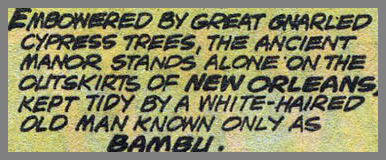

In [ ]:
image_url = Path('../experiment/cache/Strange_Tales_172005/_crop/Strange_Tales_172005_0_Default, grey pad.png')
image2 = Image.open(image_url)
display(image2)


In [ ]:
if IN_MAC:
    output = generate(
        model, processor, image2, prompt,  # type: ignore
        max_tokens=100, temp=0.0, top_p=1.0,
        verbose=True
    )
else:
    prompt, generation_args = idefics_generation_args(processor, model.device, image2, resulting_messages)
    generated_ids = model.generate(**generation_args)
    generated_texts = processor.batch_decode(
        generated_ids[:, generation_args["input_ids"].size(1):], skip_special_tokens=True)
    cprint(prompt, generated_texts)
    


Image: <PIL.PngImagePlugin.PngImageFile image mode=RGB size=386x160> 

Prompt: User:<image>Do perform optical character recognition OCR on the image, which contains speech balloons from a comic book. The text is in English. Carefully extract the text exactly as it appears, ensuring that you preserve the original capitalization, punctuation, and formatting.<end_of_utterance>
Assistant:
EMBODIED WHEREBY BY GREAT ONYX-HARLEDLED CYPRESS TREES, THE ANCIENT MANDORS STANDS ALLONE ON THE QUIETSKIRKIES OF NEEEN ORLEAANS, KEPT TIDY BY A WHITE-HAIRRIED COLD MAN KNOWN ONLY AS BAMBABU...<end_of_utterance>
Prompt: 118.827 tokens-per-sec
Generation: 27.160 tokens-per-sec


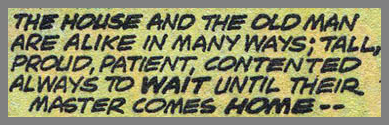

In [ ]:
image_url = Path('../experiment/cache/Strange_Tales_172005/_crop/Strange_Tales_172005_1_Default, grey pad.png')
image3 = Image.open(image_url)
display(image3)


In [ ]:
if IN_MAC:
    output = generate(
        model, processor, image3, prompt,  # type: ignore
        max_tokens=100, temp=0.0, top_p=1.0,
        verbose=True
    )
else:
    prompt, generation_args = idefics_generation_args(processor, model.device, image3, resulting_messages)
    generated_ids = model.generate(**generation_args)
    generated_texts = processor.batch_decode(
        generated_ids[:, generation_args["input_ids"].size(1):], skip_special_tokens=True)
    cprint(prompt, generated_texts)


Image: <PIL.PngImagePlugin.PngImageFile image mode=RGB size=389x125> 

Prompt: User:<image>Do perform optical character recognition OCR on the image, which contains speech balloons from a comic book. The text is in English. Carefully extract the text exactly as it appears, ensuring that you preserve the original capitalization, punctuation, and formatting.<end_of_utterance>
Assistant:
THE HOUSE AND THE OLD MAN ARE : ALLIKE IN MANY WAYS; TALLY PROUD, PATIENT, CONTENTED THEIR ALWAYS TO WAIT UNTIL THEIR MASTER COMES HOME ...<end_of_utterance>
Prompt: 118.874 tokens-per-sec
Generation: 27.157 tokens-per-sec


In [ ]:
del processor
del model
if IN_LINUX:
    torch.cuda.empty_cache()
if IN_MAC:
    mx.metal.clear_cache()
import gc
gc.collect()


129

----
# Idefics experiments


# Experiment directory

In [ ]:
EXP_DIR = "../experiment"


# Setup ngrok (Colab)

The experiments can generate hundreds of images, and maintaining the **PIL** images in memory is not efficient. All the generated images are cached and visualized on demand through a URL pointing to the local cache. This approach prevents the kernel from being overloaded with **PIL** images, with the front-end responsible for fetching the image and the backend web server (not the kernel) for serving the image in another process. This method is quick and efficient. As an added bonus, the saved notebook remains lean and fit; it doesn't store the Base64 versions of all the output cell images.

Unfortunately, this approach does not work as is in **Colab**. Google Colab runs on an older Ubuntu 18.04 VM, so all the usual networking challenges with Docker, or whatever VMs Google is using, apply. Google also goes to great lengths to avoid exposing its internal architecture. We have two options:
- Let the Jupyter kernel serve the images itself, which is slow and memory-consuming.
- Use a tunnel to map localhost (server) to whatever IP and port the front-end (the browser you're currently using) is running on. We can use **ngrok** for this, but *ngrok* is a commercial service that has been abused and now requires confirmation the first time the tunnel connects, which can be inconvenient for the user. It also requires the user to open a free account and obtain an auth token.

You choose.

If the notebook is running in Colab and ngrok has been successfully installed and the tunnel has been created, the default setting is USE_PIL=False. You can set the environment variable USE_PIL=True to force the use of PIL images, but note that in certain circumstances, Colab will complain because the free tiers are usually memory constrained.


In [ ]:
if 'USE_TUNNEL' not in os.environ:
    os.environ['USE_TUNNEL'] = 'True' if FC.IN_COLAB else 'False'
if 'USE_PIL' not in os.environ:
    os.environ['USE_PIL'] = 'True' if FC.IN_COLAB and os.environ['USE_TUNNEL'] == 'False' else 'False'


In [ ]:
SERVER = None
if (os.environ['USE_PIL'].lower() == 'false') and os.environ['USE_TUNNEL'].lower() == 'true':
    SERVER = setup_ngrok(WebServerBottle, Path(EXP_DIR))


# Idefics initialization

## Processor

In [ ]:
#| exporti

QuantT: TypeAlias = Literal['float16'] | Literal['8bit'] | Literal['4bit']

def _setup_processor(model_id: str = "HuggingFaceM4/idefics2-8b", **kwargs):
    quant: QuantT = kwargs.pop('quant', '8bit')
    if IN_MAC and quant != 'float16':
        from mlx_vlm.utils import get_model_path, load_processor
        model_id = f'mlx-community/idefics2-8b-{quant}'
        processor_config = kwargs.pop('processor_config', None)
        model_path = get_model_path(model_id)
        if processor_config is None:
            processor = load_processor(model_path)
        else:
            processor = load_processor(model_path, processor_config=processor_config)
    else:
        processor = AutoProcessor.from_pretrained(
            model_id, 
            do_image_splitting=False  #  cropped boxes are usually small
        )
    return processor


## Model loading

In [ ]:
#| exporti

def _setup_model(quant: QuantT, flashattn: bool=True, lazy: bool = False):
    if IN_MAC and quant != 'float16':
        from mlx_vlm.utils import load_model, get_model_path
        model_id = f"mlx-community/idefics2-8b-{quant}"
        model_path = get_model_path(model_id)
        model = load_model(model_path, lazy=lazy)
    else:
        kwargs: dict = dict(
            torch_dtype=torch.float16,
        )
        if quant == 'float16':
            pass
        else:
            from transformers import BitsAndBytesConfig
            quantization_config = None
            if quant == '8bit':
                quantization_config = BitsAndBytesConfig(
                    load_in_8bit=True,
                )
            if quant == '4bit':
                quantization_config = BitsAndBytesConfig(
                    load_in_4bit=True,
                    bnb_4bit_quant_type="nf4",
                    bnb_4bit_use_double_quant=True,
                    bnb_4bit_compute_dtype=torch.float16
                )
            if quantization_config is not None:
                kwargs.update(quantization_config=quantization_config)
        if flashattn and not IN_MAC:
            kwargs.update(_attn_implementation="flash_attention_2")
        model = Idefics2ForConditionalGeneration.from_pretrained(
            "HuggingFaceM4/idefics2-8b", 
            device_map='auto', 
            **kwargs)
    return model

In [ ]:
#| exporti

prompt_text_tmpl = (
        "Please perform optical character recognition (OCR) on this image, which displays "
        "speech balloons from a comic book. The text is in {}. Extract the text and "
        "format it as follows: transcribe in standard sentence case, avoid using all capital "
        "letters. Provide the transcribed text clearly and double check the sentence is not all capital letters.")

# prompt_text_tmpl = ("Please perform optical character recognition (OCR) on this image, which displays "
#         f"speech balloons from a manga comic. The text is in {}. Extract the text and "
#         "format it without newlines. Provide the transcribed text clearly.")

# prompt_text_tmpl = ("Please perform optical character recognition (OCR) on this image, which displays "
#         "speech balloons from a comic book. The text is in {}. Extract the text and "
#         "format it as follows: transcribe in standard sentence case (avoid using all capital "
#         "letters) and use asterisks to denote any words that appear in bold within the image. "
#         "Provide the transcribed text clearly.")

# prompt_text_tmpl = ("Please perform optical character recognition (OCR) on this image, which displays "
#         "speech balloons from a comic book. The text is in {}. Extract the text and "
#         "format it as follows: transcribe in standard sentence case, capitalized. Avoid using "
#         "all capital letters. In comics, it is common to use two hyphens '--' to interrupt a sentence. "
#         "Retain any hyphens as they appear in the original text. Provide the transcribed text "
#         "clearly, ensuring it is capitalized where appropriate, including proper nouns.")

prompt_text_tmpl = (
        "Please perform optical character recognition (OCR) on this image, which displays "
        "speech balloons from a comic book. The text is in {}. Extract the text and "
        "format it as follows: transcribe in standard sentence case, capitalized. Avoid using "
        "all capital letters, but ensure it is capitalized where appropriate, including proper nouns. "
        "Provide the transcribed text clearly. Double check the text is not all capital letters.")


# prompt_text_tmpl = (
#         "Please perform optical character recognition (OCR) on this image, which contains speech "
#         "balloons from a comic book. The text is in English. Carefully transcribe the text, "
#         "ensuring that you preserve the original formatting and line breaks as they appear "
#         "in the speech balloon."
# )

prompt_text_tmpl = (
        "Perform optical character recognition OCR on this image, which contains speech "
        "balloons from a comic book. The text is in {}."
)

prompt_text_tmpl = (
        "Do perform optical character recognition OCR on the image, which contains speech "
        "balloons from a comic book. The text is in {}. Carefully extract the text exactly "
        "as it appears, ensuring that you preserve the original capitalization, punctuation, and "
        "formatting."
)

default_prompt_text_tmpl = prompt_text_tmpl

# IdeficsOCR

In [ ]:
#| export

class IdeficsOCR:
    prompt_text_tmpl: str = default_prompt_text_tmpl
    PROCESSOR: Any = None
    MODEL: Any = None


    @classmethod
    def setup_processor(cls, model_id: str='HuggingFaceM4/idefics2-8b', quant: QuantT='float16'):
        cls.PROCESSOR = _setup_processor(model_id, quant=quant)
        return cls.PROCESSOR
    
    @classmethod
    def setup_model(cls, quant: QuantT='float16', flashattn: bool=True):
        cls.MODEL = _setup_model(quant, flashattn)
        return cls.MODEL
    
    @staticmethod
    def is_idefics2_available() -> bool:
        return IdeficsOCR.PROCESSOR is not None and IdeficsOCR.MODEL is not None
    is_model_ready = is_idefics2_available
    
    def setup_idefics2(self):
        if self.PROCESSOR is None:
            type(self).setup_processor(quant=self.quant)
        if self.MODEL is None:
            type(self).setup_model(self.quant, self.flashattn)
    setup = setup_idefics2

    def cleanup(self):
        try: del self.PROCESSOR
        except Exception: pass
        try: del self.MODEL
        except Exception: pass
        if IN_MAC:
            mx.metal.clear_cache()
        else:
            torch.cuda.empty_cache()
        import gc
        gc.collect()
        self.MODEL = self.PROCESSOR = None

    def _generation_args_mac(self, image: Image.Image, resulting_messages: list[dict]):
        prompt = self.PROCESSOR.apply_chat_template(resulting_messages, add_generation_prompt=True)
        max_new_tokens = 100
        temperature = 0.0
        top_p = 1.0
        # repetition_penalty = 1.2
        # repetition_context_size = 20
        generation_args: dict = {
            'model': self.MODEL,
            'processor': self.PROCESSOR,
            "image": image,
            'prompt': prompt,
            "max_tokens": max_new_tokens,
            'temp': temperature,
            'top_p': top_p,
            # 'repetition_penalty': repetition_penalty,
            # 'repetition_context_size': repetition_context_size,
        }
        return prompt, generation_args

    def _generation_args(self, image: Image.Image, resulting_messages: list[dict]):
        prompt = self.PROCESSOR.apply_chat_template(resulting_messages, add_generation_prompt=True)
        
        max_new_tokens = 512
        repetition_penalty = 1.2
        decoding_strategy = "Greedy"
        temperature = 0.4
        top_p = 0.8

        generation_args = {
            "max_new_tokens": max_new_tokens,
            "repetition_penalty": repetition_penalty,
        }

        assert decoding_strategy in [
            "Greedy",
            "Top P Sampling",
        ]

        if decoding_strategy == "Greedy":
            generation_args["do_sample"] = False
        elif decoding_strategy == "Top P Sampling":
            generation_args["temperature"] = temperature
            generation_args["do_sample"] = True
            generation_args["top_p"] = top_p

        inputs = self.PROCESSOR(text=prompt, images=[image], return_tensors="pt")
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        generation_args.update(inputs)
        return prompt, generation_args

    def _generate_mac(self, image: Image.Image, resulting_messages: list[dict]):
        prompt, generation_args = self._generation_args_mac(image, resulting_messages)
        output = generate(
            **generation_args, 
            verbose=False#True
        )
        return prompt, [output.strip('<end_of_utterance>').strip(' ')]

    def _generate(self, image: Image.Image, resulting_messages: list[dict]):
        prompt, generation_args = self._generation_args(image, resulting_messages)
        generated_ids = self.MODEL.generate(**generation_args)
        generated_texts = self.PROCESSOR.batch_decode(
            generated_ids[:, generation_args["input_ids"].size(1):], skip_special_tokens=True)
        return prompt, generated_texts

    def postprocess_ocr(self, text):
        return ' '.join(remove_multiple_whitespaces(text).splitlines())
    
    def show_info(self):
        cfg = IdeficsOCR.MODEL.config if IdeficsOCR.MODEL is not None else None
        quant = self.quant
        flashattn = self.flashattn
        if cfg is not None:
            if hasattr(cfg, 'quantization_config'):
                qcfg = cfg.quantization_config
                quant = '4bit' if qcfg.load_in_4bit else '8bit'
            if hasattr(cfg, '_attn_implementation'):
                flashattn = cfg._attn_implementation == 'flash_attention_2'
        cprint(
            f"{'Quantization':>17}: {quant!r}\n"
            f"{'Flash attention 2':>17}: {flashattn if IN_LINUX else 'N/A'}\n"
            f"{'VRAM':>17}: {get_gpu_vram(False)}/{get_gpu_vram()} MiB\n"
        )


    def __call__(
        self,
        img_or_path: Image.Image | Path | str,
        lang: str | None = None,
        prompt_text: str | None = None,
        config: str | None = None,
        show_prompt: bool = False,
        **kwargs,
    ) -> str:
        self.setup_idefics2()
        if not self.is_idefics2_available():
            raise RuntimeError("Idefics is not installed or not found.")
        resulting_messages = [
            {
                "role": "user",
                "content": [{"type": "image"}] + [
                    {"type": "text", "text": prompt_text or self.prompt_text_tmpl.format(lang or self.lang)}
                ]
            }
        ]
        image = load_image(img_or_path)
        gen_func = self._generate_mac if IN_MAC and self.quant != 'float16' else self._generate
        prompt, generated_texts = gen_func(image, resulting_messages)
        if show_prompt:
            cprint("INPUT:", prompt, "\nOUTPUT:", generated_texts)
        return generated_texts[0]#.strip('"')


    def __init__(self, 
            lang: str | None = None, 
            quant: Any | None = None,
            flashattn: bool | None = None, 
            device: str | None = None, 
            *,
            prompt_text_tmpl: str | None = None, 
            lazy: bool | None = False,
            **_
        ):
        self.lang = lang
        self.prompt_text_tmpl = prompt_text_tmpl or self.prompt_text_tmpl
        self.quant: QuantT = quant or 'float16'#'4bits'
        self.flashattn = flashattn or True
        self.device = device or default_device()
        if not lazy and not self.is_idefics2_available():
            self.setup_idefics2()



OCRExperimentContext.register_model('Idefics', IdeficsOCR, {
            "quant": 'float16',
            "flashattn": True,
        })


# Context

| quant, attn \ platform | Mem   | Mac  | Linux | Windows | Colab T4 | Colab L4/H100 |
| ---                    | ---   | ---  | ---   | ---     | ---      | ---           |
| **float16**            | 17 GB | ✅   | ✅    | ?       | ❌       | ✅            |
| **float16 + attn**     | 17 GB | ❌   | ✅    | ?       | ❌       | ✅            |
| **8bit**               | 10 GB | ✅   | ✅    | ?       | ✅       | ✅            |
| **8bit + attn**        | 10 GB | ❌   | ✅    | ?       | ❌       | ✅            |
| **4bit**               |  6 GB | ✅   | ✅    | ?       | ✅       | ✅            |
| **4bit + attn**        |  6 GB | ❌   | ✅    | ?       | ❌       | ✅            |


In [ ]:
try: CONTEXT.cleanup_model()  # type: ignore
except: pass

quant = '4bit' if IN_MAC else 'float16'
CONTEXT = OCRExperimentContext('Idefics', EXP_DIR, quant=quant, load=False)
CONTEXT.show()


Current Configuration:

Locale: System default
Default Profile: Built-in
Saved Profiles:
- victess: /Users/vic/dev/repo/DL-mac/cleaned/victess.conf
- vicmang: /Users/vic/dev/repo/DL-mac/cleaned/vicmang.conf

Profile Editor: cursor
Cache Directory: System default
Default Torch Model Path: /Users/vic/Library/Caches/pcleaner/model/comictextdetector.pt
Default CV2 Model Path: /Users/vic/Library/Caches/pcleaner/model/comictextdetector.pt.onnx
GUI Theme: System default

--------------------

Config file located at: /Users/vic/Library/Application Support/pcleaner/pcleanerconfig.ini
System default cache directory: /Users/vic/Library/Caches/pcleaner


config cache_dir: None
       model_path: Path('/Users/vic/Library/Caches/pcleaner/model/comictextdetector.pt')
           device: 'mps'

force_PIL: False
       use_tunnel: False
       server_url: 
   experiment dir: ../experiment
       source_dir: ../experiment/source
        cache_dir: ../experiment/cache

Experiment runs:
Idefics-crop-post: 0

In [ ]:
ocr_model = CONTEXT.setup_ocr_model(False)
ocr_model.show_info()


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Quantization: '4bit'
Flash attention 2: N/A
             VRAM: 5261/65536 MiB

In [ ]:
CONTEXT.reset_results(image_idx=20)
result = CONTEXT.result('Idefics', 20, 0, CropMethod.PADDED_8)
result


No chat template is set for this processor, falling back to a default class-level template. This is very error-prone, because models are often trained with templates different from the class default! Default chat templates are a legacy feature and will be removed in Transformers v4.43, at which point any code depending on them will stop working. We recommend setting a valid chat template before then to ensure that this model continues working without issues.


,"Embodiesd by great wharled cypresses trees, the ancient manors stands alone on the quietskirkies of newn orleans, kept tidy by a white-hairied old man known only as bambu.0.91"


In [ ]:
CONTEXT.result('Idefics', 20, 7, CropMethod.INITIAL_BOX)

,The echo of the old man's footsteps fades down in the hall as ....0.96


In [ ]:
CONTEXT.result('Idefics', 20, 1, CropMethod.DEFAULT)

,"The house and the cold man "" are alike in many ways; "" tally, proud, patient, contented always tid want until their master comes home ""0.94"


# Test images


In [ ]:
IMAGE_PATHS = CONTEXT.image_paths

[f"{i:02}: {_.name}" for i,_ in enumerate(IMAGE_PATHS)]


['00: Action_Comics_1960-01-00_(262).JPG',
 '01: Adolf_Cap_01_008.jpg',
 '02: Barnaby_v1-028.png',
 '03: Barnaby_v1-029.png',
 '04: Buck_Danny_-_12_-_Avions_Sans_Pilotes_-_013.jpg',
 '05: Cannon-292.jpg',
 '06: Contrato_con_Dios_028.jpg',
 '07: Erase_una_vez_en_Francia_02_88.jpg',
 '08: FOX_CHILLINTALES_T17_012.jpg',
 '09: Furari_-_Jiro_Taniguchi_selma_056.jpg',
 '10: Galactus_12.jpg',
 '11: INOUE_KYOUMEN_002.png',
 '12: MCCALL_ROBINHOOD_T31_010.jpg',
 '13: MCCAY_LITTLENEMO_090.jpg',
 '14: Mary_Perkins_On_Stage_v2006_1_-_P00068.jpg',
 '15: PIKE_BOYLOVEGIRLS_T41_012.jpg',
 '16: Sal_Buscema_Spaceknights_&_Superheroes_Ocular_Edition_1_1.png',
 '17: Sal_Buscema_Spaceknights_&_Superheroes_Ocular_Edition_1_1_K.png',
 '18: Sal_Buscema_Spaceknights_&_Superheroes_Ocular_Edition_1_2.png',
 '19: Spirou_Et_Fantasio_Integrale_06_1958_1959_0025_0024.jpg',
 '20: Strange_Tales_172005.jpg',
 '21: Strange_Tales_172021.jpg',
 '22: Tarzan_014-21.JPG',
 '23: Tintin_21_Les_Bijoux_de_la_Castafiore_page_39.jp

# EXP_RUN

In [ ]:
EXP_RUN = CONTEXT.experiment_run()
assert EXP_RUN is not None
RUN_NAME = EXP_RUN.name
RUN_NAME


'Idefics-crop-post'

# Base image


In [ ]:
BASE_IMAGE_IDX: ImgIdT = cast(ImgIdT, CONTEXT.normalize_idx("Strange_Tales_172005.jpg"))

assert BASE_IMAGE_IDX is not None
img_path = CONTEXT.final(CONTEXT.image_paths[BASE_IMAGE_IDX])
assert img_path.exists()

img_visor = ImageContextVisor(CONTEXT, BASE_IMAGE_IDX)
img_visor


In [ ]:
page_lang = 'English'

IMAGE_CONTEXT = ImageContext(CONTEXT, BASE_IMAGE_IDX, page_lang=page_lang)
test_eq(IMAGE_CONTEXT.page_data is not None, True)
RenderJSON(IMAGE_CONTEXT.json_data, 360, 2)


# Box id


In [ ]:
BOX_IDX = 0

### Crop methods

In [ ]:
image_experiment = ExperimentOCR.from_image(CONTEXT, RUN_NAME, IMAGE_CONTEXT.image_idx)


In [ ]:
method = CropMethod.INITIAL_BOX

result = image_experiment.result(BOX_IDX, method, ocr=False)
assert result is not None

image = result.image
assert image is not None
text = CONTEXT.ocr_model(image, lang=page_lang)
result.ocr = postprocess_ocr(text)
result


,Smibowhered by great ownaharled by great ownaharled by great ownaharled by great ownaharled by great ownaharled by great ownaharled by great ownaharled by great ownaharled by great ownaharled by great o0.30


In [ ]:
image_experiment.result(BOX_IDX, CropMethod.PADDED_4)

,"Embodied by great gwarlfied cypress trees, the ancient manor stands aloone con the cutlskirts of neenin corleaens, kept tiddy by a white-hairied old man knowing only a as bammbbul...0.89"


In [ ]:
image_experiment.result(BOX_IDX, CropMethod.PAD_8_FRACT_0_2)

,,


----
# Visualize results

In [ ]:
result_visor = ResultVisor(image_experiment)
result_visor


----
# Visualize Experiment

In [ ]:
exp_visor = ExperimentVisor(image_experiment)
exp_visor


----
# EEAaO

In [ ]:
idefics_experiment = ExperimentsVisor(
                        CONTEXT, 
                        'Idefics', 
                        image_idx=BASE_IMAGE_IDX, 
                        box_idx=13, 
                        method=CropMethod.DEFAULT_GREY_PAD
                    )
idefics_experiment


----

In [ ]:
CONTEXT.cleanup_model()

if SERVER is not None:
    SERVER.stop()
    SERVER = None
    os.environ['USE_TUNNEL'] = 'False'


# Colophon
----


In [ ]:
import fastcore.all as FC
from nbdev.export import nb_export


In [ ]:
if FC.IN_NOTEBOOK:
    nb_export('ocr_idefics.ipynb', '../testbed')
